ValueError: too many values to unpack (expected 2)

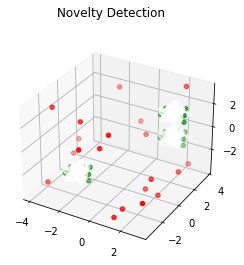

In [1]:
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from sklearn import svm
import matplotlib.font_manager
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

SPACE_SAMPLING_POINTS = 100
TRAIN_POINTS = 100

# Define the size of the space which is interesting for the example
X_MIN = -5
X_MAX = 5
Y_MIN = -5
Y_MAX = 5
Z_MIN = -5
Z_MAX = 5

# Generate a regular grid to sample the 3D space for various operations later
xx, yy, zz = np.meshgrid(np.linspace(X_MIN, X_MAX, SPACE_SAMPLING_POINTS),
                         np.linspace(Y_MIN, Y_MAX, SPACE_SAMPLING_POINTS),
                         np.linspace(Z_MIN, Z_MAX, SPACE_SAMPLING_POINTS))

# Generate training data by using a random cluster and copying it to various
# places in the space
X = 0.3 * np.random.randn(TRAIN_POINTS, 3)
X_train = np.r_[X + 2, X - 2, X + [2, 2, 0]]

# Generate some regular novel observations using the same method and
# distribution properties
X = 0.3 * np.random.randn(20, 3)
X_test = np.r_[X + 2, X - 2, X + [2, 2, 0]]

# Generate some abnormal novel observations using a different distribution
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 3))

# Create a OneClassSVM instance and fit it to the data
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)

# Predict the class of the various input created before
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# And compute classification error frequencies
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# Calculate the distance from the separating hyperplane of the SVM for the
# whole space using the grid defined in the beginning
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel(), zz.ravel()])
Z = Z.reshape(xx.shape)

# Create a figure with axes for 3D plotting
fig = plt.figure()
ax = fig.gca(projection='3d')
fig.suptitle("Novelty Detection")

# Plot the different input points using 3D scatter plotting
b1 = ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c='white')
b2 = ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c='green')
c = ax.scatter(X_outliers[:, 0], X_outliers[:, 1], X_outliers[:, 2], c='red')

# Plot the separating hyperplane by recreating the isosurface for the distance
# == 0 level in the distance grid computed through the decision function of the
# SVM. This is done using the marching cubes algorithm implementation from
# scikit-image.
verts, faces = measure.marching_cubes(Z, 0)
# Scale and transform to actual size of the interesting volume
verts = verts * \
    [X_MAX - X_MIN, Y_MAX - Y_MIN, Z_MAX - Z_MIN] / SPACE_SAMPLING_POINTS
verts = verts + [X_MIN, Y_MIN, Z_MIN]
# and create a mesh to display
mesh = Poly3DCollection(verts[faces],
                        facecolor='orange', edgecolor='gray', alpha=0.3)
ax.add_collection3d(mesh)

# Some presentation tweaks
ax.set_xlim((-5, 5))
ax.set_ylim((-5, 5))
ax.set_zlim((-5, 5))

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend([mpatches.Patch(color='orange', alpha=0.3), b1, b2, c],
          ["learned frontier", "training observations",
           "new regular observations", "new abnormal observations"],
          loc="lower left",
          prop=matplotlib.font_manager.FontProperties(size=11))
ax.set_title(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers))
fig.show()